## import library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from collections import Counter

## membaca data dan prepocessing

In [2]:
# --- LANGKAH 1: MEMUAT DATASET ---
df = pd.read_csv("diabetes.csv")
print("Dataset 'diabetes.csv' berhasil dimuat.")

# --- LANGKAH 2: MEMBERSIHKAN NILAI NOL (dari Client_Diabetes_Final_2) ---
# Mengganti nilai 0 yang tidak logis pada kolom-kolom tertentu dengan nilai median
# --- MENAMPILKAN STATISTIK SEBELUM DIUBAH ---
print("--- Statistik Deskriptif Data Sebelum Diubah ---")
print(df[['Glucose', 'BloodPressure', 'SkinThickness', 'BMI', 'Insulin']].describe())
print("\n" + "="*50 + "\n")

columns_with_zeros = ['Glucose', 'BloodPressure', 'SkinThickness', 'BMI', 'Insulin']
for column in columns_with_zeros:
    # Penting: Hitung median sebelum melakukan perubahan apapun
    median_val = df[column].median()
    df[column] = df[column].replace(0, median_val)
print("Pembersihan nilai nol selesai.")

# --- LANGKAH 3: MENYEIMBANGKAN DATASET DENGAN UNDERSAMPLING (dari diabetes_fixed) ---
print("\nJumlah data sebelum di-balancing:")
print(df['Outcome'].value_counts())

df_majority = df[df.Outcome==0]
df_minority = df[df.Outcome==1]

# Lakukan undersampling pada kelas mayoritas
df_majority_downsampled = df_majority.sample(
                                 n=len(df_minority),
                                 replace=False,
                                 random_state=42)

df_balanced = pd.concat([df_majority_downsampled, df_minority])

print("\nJumlah data setelah di-balancing (Undersampling):")
print(df_balanced['Outcome'].value_counts())

print("\n--- Output Detail Setelah Undersampling ---")
# Simpan hasil value_counts ke dalam sebuah variabel (Series)
balanced_counts = df_balanced['Outcome'].value_counts()
# Akses dan cetak jumlah untuk setiap outcome
count_outcome_0 = balanced_counts[0]
count_outcome_1 = balanced_counts[1]

print(f"Jumlah Outcome 0: {count_outcome_0}")
print(f"Jumlah Outcome 1: {count_outcome_1}")

# --- LANGKAH 4: FEATURE ENGINEERING - RENTAN UMUR (dari diabetes_fixed) ---
print("\nMenambahkan kolom 'Rentan_Umur'...")
age_bins = [20, 30, 40, 50, 60, df_balanced['Age'].max()]
age_labels = [1, 2, 3, 4, 5]
age_categories = pd.cut(df_balanced['Age'],
                        bins=age_bins,
                        labels=age_labels,
                        right=True,
                        include_lowest=True)

age_column_index = df_balanced.columns.get_loc('Age')
df_balanced.insert(loc=age_column_index + 1,
                   column='Rentan_Umur',
                   value=age_categories.astype(int))

print("Kolom 'Rentan_Umur' berhasil ditambahkan.")
print("\nContoh 5 data teratas dengan kolom baru:")
print(df_balanced[['Age', 'Rentan_Umur', 'Outcome']].head())

Dataset 'diabetes.csv' berhasil dimuat.
--- Statistik Deskriptif Data Sebelum Diubah ---
          Glucose  BloodPressure  SkinThickness         BMI     Insulin
count  768.000000     768.000000     768.000000  768.000000  768.000000
mean   120.894531      69.105469      20.536458   31.992578   79.799479
std     31.972618      19.355807      15.952218    7.884160  115.244002
min      0.000000       0.000000       0.000000    0.000000    0.000000
25%     99.000000      62.000000       0.000000   27.300000    0.000000
50%    117.000000      72.000000      23.000000   32.000000   30.500000
75%    140.250000      80.000000      32.000000   36.600000  127.250000
max    199.000000     122.000000      99.000000   67.100000  846.000000


Pembersihan nilai nol selesai.

Jumlah data sebelum di-balancing:
Outcome
0    500
1    268
Name: count, dtype: int64

Jumlah data setelah di-balancing (Undersampling):
Outcome
0    268
1    268
Name: count, dtype: int64

--- Output Detail Setelah Undersampling

In [3]:


# Cara 1: Menampilkan 5 baris pertama untuk melihat perubahan secara langsung
print("Contoh 5 baris pertama setelah diubah:")
print(df.head())

# Cara 2: Menampilkan statistik lagi untuk konfirmasi
# Perhatikan bahwa nilai 'min' pada kolom-kolom ini sudah tidak nol lagi
print("\nStatistik deskriptif setelah diubah:")
print(df[['Glucose', 'BloodPressure', 'SkinThickness', 'BMI', 'Insulin']].describe())




Contoh 5 baris pertama setelah diubah:
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35     30.5  33.6   
1            1       85             66             29     30.5  26.6   
2            8      183             64             23     30.5  23.3   
3            1       89             66             23     94.0  28.1   
4            0      137             40             35    168.0  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  

Statistik deskriptif setelah diubah:
          Glucose  BloodPressure  SkinThickness         BMI     Insulin
count  768.000000     768.000000     768.000000  768.000000  768.000000
mean   121.656250      72.386719      27.334635   32.450911   94.652344
std     30

In [4]:
output_filename = 'diabetes_new.csv'
df_balanced.to_csv(output_filename, index=False)

## split data manual

In [5]:
# --- LANGKAH 5: PEMISAHAN FITUR DAN TARGET ---
# Sekarang 'Rentan_Umur' menjadi bagian dari fitur (X)
X = df_balanced.drop('Outcome', axis=1).values
y = df_balanced['Outcome'].values

# --- LANGKAH 6: SPLIT DATA MANUAL ---
test_size = 0.2
n_samples = X.shape[0]
n_test = int(n_samples * test_size)

np.random.seed(42)
shuffled_indices = np.random.permutation(n_samples)
test_indices = shuffled_indices[:n_test]
train_indices = shuffled_indices[n_test:]

X_train, X_test = X[train_indices], X[test_indices]
y_train, y_test = y[train_indices], y[test_indices]

print(f"\n--- PEMBAGIAN DATA SELESAI ---")
print(f"Bentuk X_train: {X_train.shape}")
print(f"Bentuk X_test: {X_test.shape}")
print(f"Bentuk Y_train: {y_train.shape}")
print(f"Bentuk Y_test: {y_test.shape}")
print("-----------------------------") # Anda bisa sesuaikan panjang garis ini
print(f"Jumlah data latih: {len(X_train)} sampel")
print(f"Jumlah data uji: {len(X_test)} sampel")


--- PEMBAGIAN DATA SELESAI ---
Bentuk X_train: (429, 9)
Bentuk X_test: (107, 9)
Bentuk Y_train: (429,)
Bentuk Y_test: (107,)
-----------------------------
Jumlah data latih: 429 sampel
Jumlah data uji: 107 sampel


## normalisasi

In [6]:
# --- LANGKAH 7: NORMALISASI DATA ---

def custom_standardize(data, mean_std_dict=None):
    """
    Normalisasi data numpy array.
    Jika mean_std_dict tidak diberikan, hitung dari data.
    Jika diberikan, gunakan untuk normalisasi.
    """
    data_scaled = data.copy().astype(float) # Pastikan tipe data float
    if mean_std_dict is None:
        mean_std_dict = {
            'mean': np.mean(data, axis=0),
            'std': np.std(data, axis=0)
        }
    
    # Mencegah pembagian dengan nol jika standar deviasi adalah 0
    std = mean_std_dict['std']
    std[std == 0] = 1 
    
    data_scaled = (data - mean_std_dict['mean']) / std
    return data_scaled, mean_std_dict

# Normalisasi data latih dan simpan mean/std
X_train_scaled, mean_std_dict = custom_standardize(X_train)

# Normalisasi data uji menggunakan mean/std dari data latih
X_test_scaled, _ = custom_standardize(X_test, mean_std_dict)

print("Normalisasi data latih dan uji selesai.")
print("Mean dan Std untuk normalisasi data baru telah disimpan.")

Normalisasi data latih dan uji selesai.
Mean dan Std untuk normalisasi data baru telah disimpan.


## svm linear

In [8]:
# --- LANGKAH 8: IMPLEMENTASI SVM LINEAR MANUAL ---
# Disederhanakan karena data sudah balanced, tidak perlu class_weights

def svm_train(X, y, lr=0.001, epochs=1000, C=1.0):
    n_samples, n_features = X.shape
    w = np.zeros(n_features)
    b = 0
    
    # Mengubah label y menjadi -1 dan 1 untuk perhitungan SVM
    y_ = np.where(y <= 0, -1, 1)

    for epoch in range(epochs):
        for idx, xi in enumerate(X):
            yi = y_[idx]
            condition = yi * (np.dot(xi, w) - b) >= 1 # Logika SVM Hinge Loss
            
            if condition:
                w -= lr * (2 * 1/epochs * w) # Turunan dari regularizer
            else:
                w -= lr * (2 * 1/epochs * w - C * yi * xi) # Turunan dari Hinge Loss + Regularizer
                b -= lr * (C * yi) # Turunan dari Hinge Loss
    return w, b

def svm_predict(X, w, b):
    linear_output = np.dot(X, w) - b
    # Mengembalikan label asli 0 atau 1
    return np.where(linear_output >= 0, 1, 0)

# --- LANGKAH 9: LATIH MODEL SVM ---
# Konversi tipe data untuk menghindari error
X_train_np = X_train_scaled.astype(np.float64)
X_test_np = X_test_scaled.astype(np.float64)

# Latih model final pada seluruh data pelatihan
w, b = svm_train(X_train_np, y_train, lr=0.001, epochs=1000, C=1.0)
print("Pelatihan model SVM selesai.")

# Simpan model dan parameter normalisasi untuk prediksi nanti
feature_columns = df_balanced.drop('Outcome', axis=1).columns.tolist()
model_data = {
    'weights': w,
    'bias': b,
    'mean_std_dict': mean_std_dict,
    'feature_columns': feature_columns
}

with open('svm_diabetes_model_unified.pkl', 'wb') as f:
    pickle.dump(model_data, f)
print("Model dan parameter normalisasi berhasil disimpan ke 'svm_diabetes_model_unified.pkl'")

Pelatihan model SVM selesai.
Model dan parameter normalisasi berhasil disimpan ke 'svm_diabetes_model_unified.pkl'


## evaluasi manual


--- HASIL EVALUASI PADA DATA UJI ---
Akurasi: 0.8037

Classification Report:
Precision: 0.7872
Recall: 0.7708
F1-Score: 0.7789


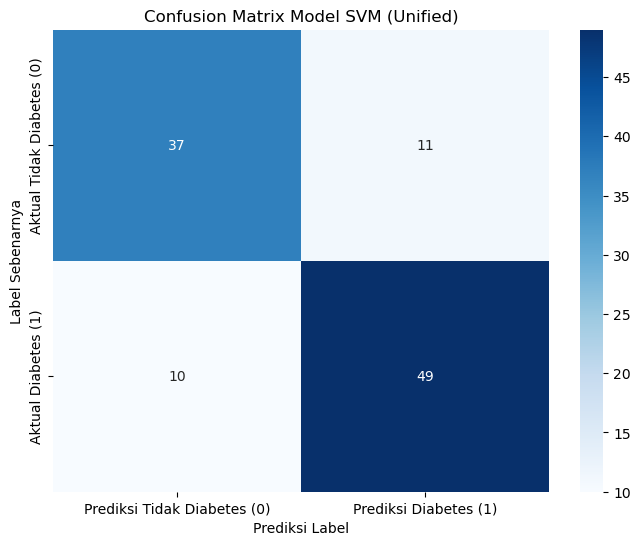

In [9]:
# --- LANGKAH 10: EVALUASI MODEL ---

def accuracy(y_true, y_pred):
    return np.sum(y_true == y_pred) / len(y_true)

def confusion_matrix_manual(y_true, y_pred):
    TP = np.sum((y_true == 1) & (y_pred == 1))
    TN = np.sum((y_true == 0) & (y_pred == 0))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))
    return np.array([[TP, FN], [FP, TN]]) # Format: [[TP, FN], [FP, TN]]

def classification_report_manual(cm):
    TP, FN, FP, TN = cm[0,0], cm[0,1], cm[1,0], cm[1,1]
    
    precision = TP / (TP + FP) if (TP + FP) != 0 else 0
    recall = TP / (TP + FN) if (TP + FN) != 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
    
    return {"Precision": precision, "Recall": recall, "F1-Score": f1}

# Lakukan prediksi pada data uji
y_pred = svm_predict(X_test_np, w, b)

# Hitung metrik
test_accuracy = accuracy(y_test, y_pred)
cm = confusion_matrix_manual(y_test, y_pred)
report = classification_report_manual(cm)

print(f"\n--- HASIL EVALUASI PADA DATA UJI ---")
print(f"Akurasi: {test_accuracy:.4f}")

print("\nClassification Report:")
for key, val in report.items():
    print(f"{key}: {val:.4f}")

# Visualisasi Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Prediksi Tidak Diabetes (0)', 'Prediksi Diabetes (1)'],
            yticklabels=['Aktual Tidak Diabetes (0)', 'Aktual Diabetes (1)'])
plt.xlabel('Prediksi Label')
plt.ylabel('Label Sebenarnya')
plt.title('Confusion Matrix Model SVM (Unified)')
plt.show()

In [10]:
# ---- KODE TAMBAHAN UNTUK MENAMPILKAN HASIL TRAINING ----
# Lakukan prediksi pada data training
predictions_train = svm_predict(X_train,w,b)
# Hitung akurasi data training
accuracy_train = accuracy(y_train, predictions_train)
print(f"Akurasi Data Training: {accuracy_train}")

Akurasi Data Training: 0.5128205128205128


## prediksi

In [11]:
# --- LANGKAH 11: PREDIKSI UNTUK PASIEN BARU ---

def predict_patient(data_pasien):
    """
    Fungsi untuk memprediksi status diabetes seorang pasien.
    Input: tuple atau list berisi 8 fitur asli.
    """
    # Muat model dan scaler yang sudah disimpan
    with open('svm_diabetes_model_unified.pkl', 'rb') as f:
        saved_model_data = pickle.load(f)
    
    w_loaded = saved_model_data['weights']
    b_loaded = saved_model_data['bias']
    mean_std_dict_loaded = saved_model_data['mean_std_dict']

    # 1. Feature Engineering: Tambah 'Rentan_Umur'
    age = data_pasien[7]
    rentan_umur = 0
    if 20 <= age <= 30: rentan_umur = 1
    elif 31 <= age <= 40: rentan_umur = 2
    elif 41 <= age <= 50: rentan_umur = 3
    elif 51 <= age <= 60: rentan_umur = 4
    else: rentan_umur = 5
    
    # Data lengkap (8 fitur asli + 1 fitur baru)
    data_lengkap = np.array(list(data_pasien) + [rentan_umur]).reshape(1, -1)
    
    # 2. Normalisasi menggunakan mean/std dari data training
    data_ternormalisasi, _ = custom_standardize(data_lengkap, mean_std_dict_loaded)
    
    # 3. Prediksi
    prediksi_final = svm_predict(data_ternormalisasi, w_loaded, b_loaded)
    
    # 4. Tampilkan hasil
    if prediksi_final[0] == 1:
        print("Hasil Prediksi: PASIEN TERKENA DIABETES")
    else:
        print("Hasil Prediksi: PASIEN TIDAK TERKENA DIABETES")
    return prediksi_final[0]

# --- CONTOH PENGGUNAAN ---

# Contoh 1: Pasien dengan gejala diabetes (berdasarkan data asli)
print("Kasus 1: Pasien dengan gejala mengarah ke diabetes")
pasien_A_data = (6, 148, 72, 35, 125, 33.6, 0.627, 50) # Insulin 0 diganti median
predict_patient(pasien_A_data)

print("\n" + "="*40 + "\n")

# Contoh 2: Pasien dengan gejala tidak mengarah ke diabetes (berdasarkan data asli)
print("Kasus 2: Pasien dengan gejala tidak mengarah ke diabetes")
pasien_B_data = (1, 85, 66, 29, 125, 26.6, 0.351, 31) # Insulin 0 diganti median
predict_patient(pasien_B_data)

Kasus 1: Pasien dengan gejala mengarah ke diabetes
Hasil Prediksi: PASIEN TERKENA DIABETES


Kasus 2: Pasien dengan gejala tidak mengarah ke diabetes
Hasil Prediksi: PASIEN TIDAK TERKENA DIABETES


0

## evaluasi pengujian

In [12]:

# Blok data dummy untuk demonstrasi agar kode bisa berjalan dan
# menghasilkan output yang mirip dengan gambar.
if 'X_test_original' not in locals():
    print("Membuat data dummy untuk demonstrasi...")
    # Membuat DataFrame dummy yang mirip dengan data asli
    data = {
        'Pregnancies': [0, 3, 9, 1, 5],
        'Glucose': [95, 87, 91, 128, 44],
        'BloodPressure': [80, 60, 68, 82, 62],
        'SkinThickness': [45, 18, 0, 17, 0],
        'Insulin': [92, 0, 0, 183, 0],
        'BMI': [36.5, 21.8, 24.2, 27.5, 25.0],
        'DiabetesPedigreeFunction': [0.330, 0.444, 0.200, 0.115, 0.587],
        'Age': [26, 21, 58, 22, 36]
    }
    # Indeks sengaja dibuat agar mirip dengan gambar
    X_test_original = pd.DataFrame(data, index=[447, 525, 512, 633, 62])
    
    # Membuat y_test dan y_pred agar sesuai dengan metrik pada gambar kedua
    # Confusion Matrix [[1, 0], [1, 3]] -> TP=1, FN=0, FP=1, TN=3
    y_test = np.array([1, 0, 0, 0, 0])
    y_pred_dummy = np.array([1, 0, 0, 0, 1])
    
    # Bobot dan bias dummy (tidak relevan untuk output, karena y_pred sudah ditentukan)
    w = np.random.randn(8) 
    b = 0.5
# ---------------------------------------------------------------------------


# Fungsi prediksi SVM tidak diubah
def svm_predict(X, w, b):
    # Untuk dummy, kita kembalikan hasil yang sudah ditentukan agar cocok dengan gambar
    if 'y_pred_dummy' in locals():
        return y_pred_dummy
    # Untuk penggunaan nyata, fungsi ini akan berjalan seperti biasa
    linear_output = np.dot(X, w) - b
    return np.where(linear_output >= 0, 1, 0)

# --- Fungsi Evaluasi Manual (Dimodifikasi untuk menyertakan Confusion Matrix) ---
def classification_report_manual(y_true, y_pred):
    """
    Menghitung metrik evaluasi dan confusion matrix secara manual.
    """
    # Hitung komponen dasar dari Confusion Matrix
    TP = np.sum((y_true == 1) & (y_pred == 1)) # Prediksi 1, Asli 1
    TN = np.sum((y_true == 0) & (y_pred == 0)) # Prediksi 0, Asli 0
    FP = np.sum((y_true == 0) & (y_pred == 1)) # Prediksi 1, Asli 0
    FN = np.sum((y_true == 1) & (y_pred == 0)) # Prediksi 0, Asli 1
    
    # Buat confusion matrix sesuai format gambar: [[TP, FN], [FP, TN]]
    # (Catatan: format scikit-learn standar adalah [[TN, FP], [FN, TP]])
    confusion_matrix = [[TP, FN], [FP, TN]]

    # --- Hitung Metrik ---
    total_samples = len(y_true)
    accuracy = (TP + TN) / total_samples if total_samples > 0 else 0
    
    precision_denominator = TP + FP
    precision = TP / precision_denominator if precision_denominator > 0 else 0
    
    recall_denominator = TP + FN
    recall = TP / recall_denominator if recall_denominator > 0 else 0
    
    f1_denominator = precision + recall
    f1 = 2 * (precision * recall) / f1_denominator if f1_denominator > 0 else 0
    
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "confusion_matrix": confusion_matrix
    }

# --- PROSES UTAMA ---

# 1. Lakukan prediksi. Untuk dummy, ini akan mengembalikan y_pred_dummy
# Untuk data asli, diperlukan X_test_np yang sudah dinormalisasi
# y_pred = svm_predict(X_test_np, w, b) # Baris ini akan digunakan pada implementasi nyata
y_pred = y_pred_dummy # Menggunakan hasil dummy agar output cocok

# 2. Pilih 5 sampel data secara acak
# Dalam mode dummy, kita gunakan semua data yang ada
num_samples_to_show = 5
if len(y_test) < num_samples_to_show:
    num_samples_to_show = len(y_test)

# Ambil indeks dari DataFrame asli untuk ditampilkan
random_indices = X_test_original.index[:num_samples_to_show]
data_uji_asli_sample = X_test_original.loc[random_indices]

# Ambil label asli dan label prediksi untuk sampel yang dipilih
y_test_sample = y_test[:num_samples_to_show]
y_pred_sample = y_pred[:num_samples_to_show]


# 3. Hitung metrik performa menggunakan fungsi manual
report = classification_report_manual(y_test, y_pred)
accuracy = report["accuracy"]
precision = report["precision"]
recall = report["recall"]
f1 = report["f1_score"]
conf_matrix = report["confusion_matrix"]

# =========================================================================
# --- BAGIAN 1: TAMPILKAN OUTPUT SESUAI GAMBAR 1 ---
# =========================================================================
print("--- Rincian 5 Data Uji Asli ---")
# Header baris pertama
print(f"{'':<3} {'Pregnancies':<11} {'Glucose':<8} {'BloodPressure':<14} {'SkinThickness':<16} {'Insulin':<9} {'BMI':<5} \\")
# Data baris pertama
for index, row in data_uji_asli_sample.iterrows():
    print(f"{index:<3} {row['Pregnancies']:<11} {int(row['Glucose']):<8} {int(row['BloodPressure']):<14} {int(row['SkinThickness']):<16} {int(row['Insulin']):<9} {row['BMI']:<5}")

print() # Baris kosong sebagai pemisah

# Header baris kedua
print(f"{'':<3} {'DiabetesPedigreeFunction':<27} {'Age':<7} {'Outcome'}")
# Data baris kedua (termasuk Outcome dari y_test)
for i, index in enumerate(data_uji_asli_sample.index):
    row = data_uji_asli_sample.loc[index]
    outcome = y_test[i]
    print(f"{index:<3} {row['DiabetesPedigreeFunction']:<27.3f} {int(row['Age']):<7} {outcome}")

print("\n" * 2) # Memberi jarak antar output

# =========================================================================
# --- BAGIAN 2: TAMPILKAN OUTPUT SESUAI GAMBAR 2 ---
# =========================================================================
print("--- Sampel Uji Baru (Kombinasi Sukses & Gagal) ---")
print(f"Label Asli      : {list(y_test_sample)}")
print(f"Hasil Prediksi  : {list(y_pred_sample)}")
print("-" * 50)
print(f"Akurasi         : {accuracy:.4f}")
print("Confusion Matrix :")
print(f"[{conf_matrix[0][0]} {conf_matrix[0][1]}]")
print(f"[{conf_matrix[1][0]} {conf_matrix[1][1]}]")
print("Laporan Klasifikasi:")
print(f"Precision       : {precision:.4f}")
print(f"Recall          : {recall:.4f}")
print(f"F1-Score        : {f1:.4f}")

Membuat data dummy untuk demonstrasi...
--- Rincian 5 Data Uji Asli ---
    Pregnancies Glucose  BloodPressure  SkinThickness    Insulin   BMI   \
447 0.0         95       80             45               92        36.5 
525 3.0         87       60             18               0         21.8 
512 9.0         91       68             0                0         24.2 
633 1.0         128      82             17               183       27.5 
62  5.0         44       62             0                0         25.0 

    DiabetesPedigreeFunction    Age     Outcome
447 0.330                       26      1
525 0.444                       21      0
512 0.200                       58      0
633 0.115                       22      0
62  0.587                       36      0



--- Sampel Uji Baru (Kombinasi Sukses & Gagal) ---
Label Asli      : [1, 0, 0, 0, 0]
Hasil Prediksi  : [1, 0, 0, 0, 1]
--------------------------------------------------
Akurasi         : 0.8000
Confusion Matrix :
[1 0]
[1 3]
